# Graph Dataset Loading and Batching
---

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
from os import path

import networkx as nx
from simgnn.datautils import *

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10,10) # use larger for presentation
matplotlib.rcParams['font.size']= 14 # use 14 for presentation

In [3]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
dtype = torch.float32
print(f'Defaults:\n |-device: {device}\n |-dtype : {dtype}')

Defaults:
 |-device: cuda
 |-dtype : torch.float32


## Dataset location

*Need to implement*: `raw_i` $\mapsto$ `Data()`$\mapsto$ `Dataset.process()` $\mapsto$`processed` dir (save processed graphs).

In [4]:
data_root = '../../../dataDIR/simgnn_data/raw'# location of all datasets
raw_path = path.join(data_root,'17Nov2020')

In [5]:
!ls $raw_path

graph_dict.pkl	simul_Ka.npy	     simul_Length.npy	  simul_t.npy
simul_A0.npy	simul_Kp.npy	     simul_P0.npy	  simul_vtxpos.npy
simul_Area.npy	simul_Lambda_ij.npy  simul_Perimeter.npy  t_Energy_maxSpeed.npy


Representation of cells in the monolayer graph:
- dict of lists with cell numbers $0, 1, \dots N$ as keys, and edges (values).
- edge ind-s **start from 1** in the cells (values), don't forget to **convert** when indexing edges tensor (e.g. `edge_ID=np.abs(ID)-1`). Negative indices indicate reversed order for vertices (cell is defined as a closed region formed by edges connected *end-to-end*). Use `np.sign(cells[c])` to find reversed edges for cell `c`.
    - e.g. get edges of cell `c` : `np.abs(mg_dict['cells'][c])-1` (`mg_dict` is monolayer graph dict loaded with `datautils.load_graph`)

In [14]:
# load dict of monolayer graph
mg_dict = load_graph(path.join(raw_path,'graph_dict.pkl'))

# Load vertex positions from simulation results: Frames x Vertices x Positions
vx_pos = load_array(path.join(raw_path,'simul_vtxpos.npy')) # T x N x 2
vx_vel = np.diff(vx_pos,n=1,axis=0) # T-1 x N x 2

# init-l vertex positions (1st frame)
vx0 = vx_pos[0]

# convert edges list to tensor
edges = torch.tensor(mg_dict['edges'],dtype=torch.long)

In [135]:
window_size = 5
Y_node = vx_vel[window_size:] # Vel[w:]
node_pos = vx_pos[window_size:-1]

# last_index = total_frames - (2+window_size)
# num_of_features = last_index+1
X_node = np.stack([ vx_vel[k:k+window_size].transpose((1,0,2))
                    for k in range(vx_pos.shape[0]-(2+window_size)+1)])

print(f'node_pos:{node_pos.shape} (T+0 pos-n)')
print(f'node_features:{X_node.shape} ([T-1:T-window_size] vel-s)\n-'+5*' -'+' -')
print(f'Y_node : {Y_node.shape} (T+0 vel-y)')
# node_pos[0] = vx_pos[window_size] ; node_pos[-1] = vx_pos[-2]
# =>vx_pos[-1]=node_pos[-1]+Y_node[-1]
# node_next = vx_pos[window_size+1:]
# assert np.sum(np.abs(Y_node+node_pos-node_next)) == 0
#
# assert np.sum(np.abs(X_node[0][:,-1,:]-vx_vel[4])) ==0

node_pos:(95, 240, 2) (T+0 pos-n)
node_features:(95, 240, 5, 2) ([T-1:T-window_size] vel-s)
- - - - - - -
Y_node : (95, 240, 2) (T+0 vel-y)


In [51]:
# t = 13
# plt.quiver(vx_pos[t,:,0],vx_pos[t,:,1], vx_vel[t,:,0], vx_vel[t,:,1],units='xy',angles='xy',scale=.1)
# plt.plot(vx_pos[t,:,0],vx_pos[t,:,1],'ro',alpha=.5)
# plt.plot(vx_pos[t+1,:,0],vx_pos[t+1,:,1],'bo',alpha=.3)

In [9]:
edge_lengths = load_array(path.join(raw_path, 'simul_Length.npy'))
Lambda_ij = load_array(path.join(raw_path,'simul_Lambda_ij.npy'))
# assert Lambda_ij.shape[1]!=edges.shape[0]

A0 = load_array(path.join(raw_path, 'simul_A0.npy'))
Area = load_array(path.join(raw_path, 'simul_Area.npy'))
Ka = load_array(path.join(raw_path, 'simul_Ka.npy'))

P0 = load_array(path.join(raw_path, 'simul_P0.npy'))
Perims = load_array(path.join(raw_path, 'simul_Perimeter.npy'))
Kp = load_array(path.join(raw_path, 'simul_Kp.npy'))

$$T_{edge:(i,j)} = \Lambda_{ij}(t)+\sum_{k\in\{cells\ for\ (i,j)\}}K_p^{(k)}(p^{(k)}-p_0^{(k)})$$
$$\pi_{cell:k} = -2K_a^{(k)}(a^{(k)}-a_0^{(k)})$$

In [8]:
# edge_lengths.max()
# plt.hist(Perims.ravel(),bins=100);

In [9]:
# plt.hist(Area.ravel(),bins=100);

In [10]:
# plt.hist((edge_lengths.ravel()), bins=50, density=True);
# plt.xlabel('Edge Lengths (a.u.)')
# plt.ylabel('Frequency (normalised)')
# plt.title('10x10 cell monolayer trial with random oscillations\n(17-Nov-2020; 100 sample frames from a movie)')
# plt.savefig('edge_length_17Nov2020.png',dpi=100);

In [11]:
# import networkx as nx
# np.random.seed(42)

# cell_samples = np.random.choice(list(mg_dict['cells'].keys()),10)

# mg_nx = nx.Graph(mg_dict['edges'])
# nx.draw(mg_nx,pos=dict(zip(range(vx0.shape[0]),vx0)),
#         node_size=20,width=4,node_color='#FF00FF',edge_color='#51C5FF')
# for c in cell_samples:
#     c_vxs = vx0[edges[(np.abs(mg_dict['cells'][c])-1)].view(-1,),:]
#     c_loc = c_vxs.mean(axis=0)
#     plt.plot(c_loc[0],c_loc[1],'ro',ms=10)
#     for vx_i in c_vxs:
#         plt.plot([vx_i[0],c_loc[0]], [vx_i[1],c_loc[1]],lw=4)

## Working with PyTorch Geometric

`torch_geometric.data.Data` attributes:
- `.x` : node features `[num_nodes, num_node_features]`
- `.edge_index` : edges as \[source, target\] node index pairs (COO format) with shape `[2, num_edges]` and `torch.long` type (int).
- `.edge_attr`: edge features with shape `[num_edges, num_edge_features]`
- `.y` : target, arbitrary shape, if node-level target then `[num_nodes, *]`, or graph-level target `[1, *]`
- `.pos`: node positions `[num_nodes, num_dims]`.
- can add additional attributes, e.g. "cells"

In [136]:
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx
import torch_geometric.transforms as T

In [164]:
window_size = 5

# vertex trajectories:(Frames,Vertices,Dims)=TxNx2
vx_pos = load_array(path.join(raw_path,'simul_vtxpos.npy')) #TxNx2
vx_vel = np.diff(vx_pos,n=1,axis=0) # velocity(1st diff approx):(T-1)xNx2

# T+0 vertex positions
node_pos = torch.from_numpy( vx_pos[window_size:-1]).type(dtype) # (num_of_frames)xNx2

# T-1 to T-window_size velocities : (num_of_frames)xNx(window_size)x2
X_node = torch.from_numpy(np.stack([ vx_vel[k:k+window_size].transpose((1,0,2))
                                    for k in range(vx_pos.shape[0]-(2+window_size)+1)])
                          ).type(dtype)
# T+0 vertex velocities
Y_node = torch.from_numpy(vx_vel[window_size:]).type(dtype) # (num_of_frames)xNx2

# monolayer graph (topology)
mg_dict = load_graph(path.join(raw_path,'graph_dict.pkl'))
edges = torch.tensor(mg_dict['edges'],dtype=torch.long) # assume constant w.r.t "t"
edge_index =  torch.cat( [edges.T.contiguous(), edges.fliplr().T.contiguous()], axis=1)

i = 0 # graph counter
sim_name = path.basename(raw_path) # folder name for the files
N_nodes = vx_pos.shape[1] # assume constant w.r.t. "t"

data = Data(num_nodes = N_nodes,
            edge_index = edge_index,
            pos = node_pos[0],
            x = X_node[0],
            y = Y_node[0])

# data.num_nodes = vx0.shape[0]
# undirected graph {ij, ji} pairs

In [165]:
!ls $data_path

graph_dict.pkl	simul_Ka.npy	     simul_Length.npy	  simul_t.npy
simul_A0.npy	simul_Kp.npy	     simul_P0.npy	  simul_vtxpos.npy
simul_Area.npy	simul_Lambda_ij.npy  simul_Perimeter.npy  t_Energy_maxSpeed.npy


In [221]:
Y_node.shape[0]

95

In [166]:
data.edge_index

tensor([[ 21,  22,   3,  ..., 235, 232, 238],
        [ 22,   3,   2,  ..., 210, 239, 233]])

- **Node features** : velocities from previous frames (~ 5 frames--> Alvaro Sanchez-Gonzalez, *et al.* 2020 \[ASG2020\])
- **Edge features** : can use edge directions (optional, might help to speed up training)
- **Current position** : technically a node feature, and needs to be normalized but not processed by the network.
- Positions (Cartesian) to polar edge attributes: `transforms.Polar` \[[link](https://pytorch-geometric.readthedocs.io/en/latest/modules/transforms.html#torch_geometric.transforms.Polar)\], I can also implement or use the `transforms.Cartesian` which computes direction vectors (position pairs -to- normalized direction vectors).
- need transform for velocity noise (use src from example transforms above and ASG2020 paper)
- Trail movie: max edge length ~ 3.25 a.u.

In [89]:
# Compare computed and original *edge lengths*
# dist_fn = T.Distance(norm=False)
# compute cartesian distances
# dist_fn(data);

### Compile graph(s) into a single dataset

In [6]:
from torch_geometric.utils import to_networkx
import networkx as nx

In [7]:
from simgnn.datasets import VertexDynamics as VtxDyn

In [8]:
vtxdata = VtxDyn('../../../dataDIR/simgnn_data')
vtxdata

VertexDynamics(95)

In [43]:
vtxdata[t].y.numpy().shape

(240, 2)

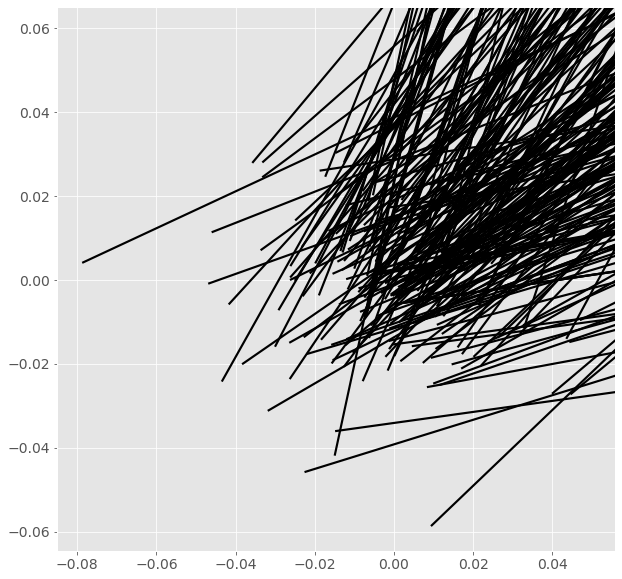

In [41]:
plt.quiver(vtxdata[t].y.numpy()[:,0],vtxdata[t].y.numpy()[:,1],
           vtxdata[t].pos.numpy()[:,0], vtxdata[t].pos.numpy()[:,1],
           units='xy',angles='xy',scale=10)

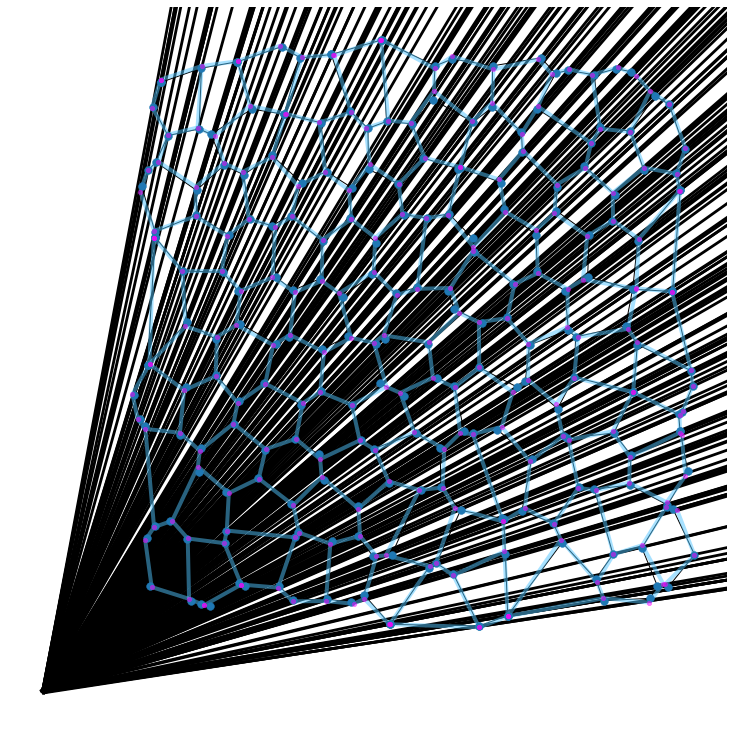

In [35]:
t=0
Dt = 3
nx.draw(to_networkx(vtxdata[t], to_undirected=True),pos=dict(enumerate(vtxdata[t].pos.numpy())), node_size=60)
plt.quiver(vtxdata[t].y.numpy()[:,0],vtxdata[t].y.numpy()[:,1],
           vtxdata[t].pos.numpy()[:,0], vtxdata[t].pos.numpy()[:,1],
           units='xy',angles='xy',scale=.1)
# plt.plot(vx_pos[t,:,0],vx_pos[t,:,1],'ro',alpha=.5)
# plt.plot(vx_pos[t+1,:,0],vx_pos[t+1,:,1],'bo',alpha=.3)
# nx.draw(to_networkx(vtxdata[t+Dt], to_undirected=True),pos=dict(enumerate(vtxdata[t+Dt].pos.numpy())),
#         node_size=20,width=4,
#         node_color='#FF00FF',edge_color='#51C5FF',alpha=.5)

In [ ]:


# cell_samples = np.random.choice(list(mg_dict['cells'].keys()),10)

# mg_nx = nx.Graph(mg_dict['edges'])
# nx.draw(mg_nx,pos=dict(zip(range(vx0.shape[0]),vx0)),
#         node_size=20,width=4,node_color='#FF00FF',edge_color='#51C5FF')
# for c in cell_samples:
#     c_vxs = vx0[edges[(np.abs(mg_dict['cells'][c])-1)].view(-1,),:]
#     c_loc = c_vxs.mean(axis=0)
#     plt.plot(c_loc[0],c_loc[1],'ro',ms=10)
#     for vx_i in c_vxs:
#         plt.plot([vx_i[0],c_loc[0]], [vx_i[1],c_loc[1]],lw=4)

## GCN tutorial

In [40]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='/tmp/Cora', name='Cora')
print('#datasets:',len(dataset),'\n1st:',dataset[0],'\nName:',dataset)

# 2-layer GCN
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

print('Training 2-layer GCN.')
tot_epoch = 200
print_freq = tot_epoch//5
for epoch in range(tot_epoch):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    if (epoch+1)%print_freq==0:
        model.eval()
        with torch.no_grad():
            _, pred = model(data).max(dim=1)
            correct = int(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
            print('Epoch {:5}| Accuracy: {:4.2f}% |'.format(epoch,100*correct / int(data.test_mask.sum())))

model.eval()
_, pred = model(data).max(dim=1)
correct = int(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
acc = correct / int(data.test_mask.sum())
print('Accuracy: {:.4f}'.format(acc))

#datasets: 1 
1st: Data(edge_index=[2, 10556], test_mask=[2708], train_mask=[2708], val_mask=[2708], x=[2708, 1433], y=[2708]) 
Name: Cora()
Training 2-layer GCN.
Epoch    39| Accuracy: 78.30% |
Epoch    79| Accuracy: 79.60% |
Epoch   119| Accuracy: 79.30% |
Epoch   159| Accuracy: 79.50% |
Epoch   199| Accuracy: 80.40% |
Accuracy: 0.8040
